Epoch 1/10
45/45 [==============================] - 20s 441ms/step - loss: 2.6563 - accuracy: 0.2042 - val_loss: 2.2486 - val_accuracy: 0.3500
Epoch 2/10
45/45 [==============================] - 20s 448ms/step - loss: 1.6138 - accuracy: 0.5250 - val_loss: 1.2507 - val_accuracy: 0.6187
Epoch 3/10
45/45 [==============================] - 20s 455ms/step - loss: 0.8271 - accuracy: 0.7688 - val_loss: 0.6126 - val_accuracy: 0.8375
Epoch 4/10
45/45 [==============================] - 21s 457ms/step - loss: 0.4856 - accuracy: 0.8646 - val_loss: 0.4578 - val_accuracy: 0.8625
Epoch 5/10
45/45 [==============================] - 20s 454ms/step - loss: 0.3082 - accuracy: 0.9222 - val_loss: 0.3264 - val_accuracy: 0.9187
Epoch 6/10
45/45 [==============================] - 20s 453ms/step - loss: 0.1780 - accuracy: 0.9556 - val_loss: 0.2221 - val_accuracy: 0.9438
Epoch 7/10
45/45 [==============================] - 20s 456ms/step - loss: 0.1234 - accuracy: 0.9667 - val_loss: 0.1617 - val_accuracy: 0.9563

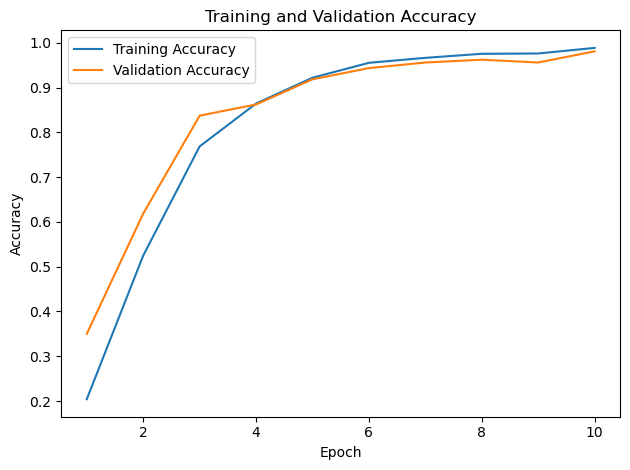

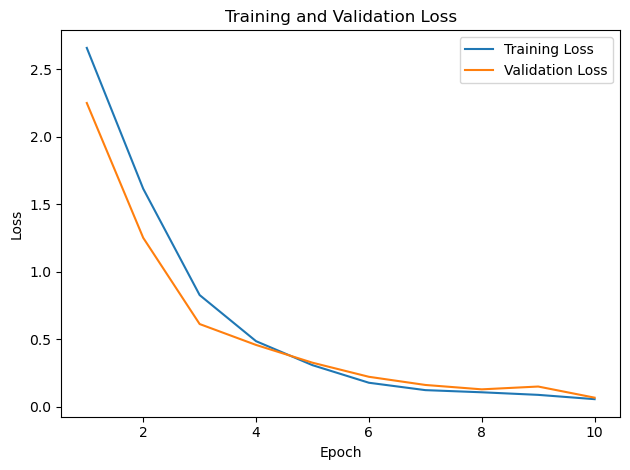

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Data = "C:/Users/USER/Project10/Dataset/train"
Categories = ["ba", "ca", "da", "dha", "ga", "ha", "ja", "ka", "la", "ma", "na", "nga", "nya", "pa", "ra", "sa", "ta", "tha", "wa", "ya"]

img_size = 100

# Function to create training data
def create_training_data():
    training_data = []
    for CATEGORY in Categories:
        path = os.path.join(Data, CATEGORY)
        class_num = Categories.index(CATEGORY)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)  # Use IMREAD_COLOR for RGB images
                img_array = cv2.resize(img_array, (img_size, img_size))
                inverted_img_array = 255 - img_array  # Invert the colors
                training_data.append([inverted_img_array, class_num])
            except Exception as e:
                pass
    random.shuffle(training_data)
    return training_data

training_data = create_training_data()

x = []
y = []

for features, label in training_data:
    x.append(features)
    y.append(label)

x = np.array(x).reshape(-1, img_size, img_size, 3)  # Use 3 channels for RGB images

# Normalize and one-hot encode the labels
x = x / 255.0
y = to_categorical(y, num_classes=len(Categories))

# Split data into 80% training and 20% testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Further split training data into 70% training and 10% validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the base model's layers
for layer in base_model.layers:
    layer.trainable = False

# Create your own classifier (top layers)
model = Sequential()
model.add(base_model)  # Add the VGG16 base model
model.add(Flatten())
model.add(Dense(512, activation='relu'))  # Custom dense layer
model.add(Dense(256, activation='relu'))  # Another custom dense layer
model.add(Dense(128, activation='relu'))  # Another custom dense layer
model.add(Dense(len(Categories), activation='softmax'))  # Output layer

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

# Training the model
history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_val, y_val))

# Get the number of epochs
num_epochs = len(history.history['accuracy'])

# Evaluation on test data
accuracy = model.evaluate(x_test, y_test)[1]
print("Accuracy on test data: {:.2f}%".format(accuracy * 100))

# Classification Report on test data
y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

classification_report_result = classification_report(y_true_labels, y_pred_labels, target_names=Categories)
print(classification_report_result)

# Plot accuracy and loss
# plt.figure(figsize=(12, 6))

# Plot accuracy
# plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Plot loss
# plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), history.history['loss'], label='Training Loss')
plt.plot(range(1, num_epochs + 1), history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()
